# Model creation playground

## Explore the input file

In [1]:
import numpy as np
from os import path
import string
import csv
from nltk.tokenize import word_tokenize
import re

import matplotlib.pyplot as plt
%matplotlib inline 

# We will just use dialogue by Jerry
input_file_path = path.join("..", "input_files", "complete_seinfeld_scripts.csv")

EOS = "eos"
words_by_jerry = []
with open(input_file_path) as input_file:
    input_data = csv.DictReader(input_file)
    for row in input_data:
        if(row['Character'] == 'JERRY'):
            for words in row['Dialogue'].split():
                for word in word_tokenize(words):
                    word = word.replace("...", "")
                    word = word.replace(".", EOS)
                    word = word.replace("?", EOS)
                    word = word.replace("!", EOS)
                    if word.isalpha():
                        words_by_jerry.append(word.lower())
print("There are {} words by Jerry in the all Seinfeld episodes!\n".format(len(words_by_jerry)))
print("Few words by Jerry:")
print(words_by_jerry[:50])

There are 169659 words by Jerry in the all Seinfeld episodes!

Few words by Jerry:
['do', 'you', 'know', 'what', 'this', 'is', 'all', 'about', 'eos', 'do', 'you', 'know', 'why', 'were', 'here', 'eos', 'to', 'be', 'out', 'this', 'is', 'out', 'and', 'out', 'is', 'one', 'of', 'the', 'single', 'most', 'enjoyable', 'experiences', 'of', 'life', 'eos', 'people', 'did', 'you', 'ever', 'hear', 'people', 'talking', 'about', 'we', 'should', 'go', 'out', 'eos', 'this', 'is']


In [2]:
import collections
n_most_common = 20
counter = collections.Counter(words_by_jerry)
print("{} most common words by jerry are:\n{}".format(n_most_common, counter.most_common(n_most_common)))
print("{} least common words by jerry are:\n{}".format(n_most_common, counter.most_common()[:-n_most_common-1:-1]))

20 most common words by jerry are:
[('eos', 23097), ('you', 6212), ('i', 6204), ('the', 5097), ('a', 3435), ('to', 3407), ('it', 3127), ('that', 2298), ('what', 2188), ('do', 1967), ('and', 1576), ('of', 1574), ('is', 1536), ('in', 1500), ('he', 1318), ('this', 1268), ('know', 1240), ('no', 1165), ('on', 1162), ('me', 1087)]
20 least common words by jerry are:
[('flinching', 1), ('theoseosthat', 1), ('fornicator', 1), ('mohair', 1), ('verge', 1), ('kom', 1), ('repack', 1), ('problemseoseos', 1), ('unhealthy', 1), ('dumped', 1), ('slough', 1), ('immature', 1), ('dente', 1), ('reston', 1), ('schnapps', 1), ('perks', 1), ('lampshades', 1), ('henry', 1), ('site', 1), ('welcoming', 1)]


In [3]:
from keras.preprocessing.text import Tokenizer

# Create a tokenizer
tokenizer = Tokenizer()

# And build the word index
tokenizer.fit_on_texts(words_by_jerry)

# This is how we can recover the word index that was computed
word_index = tokenizer.word_index

# Vocabulary size
vocabulary_size = len(word_index) + 1
print("Vocabulary size is: {}.".format(vocabulary_size))

Using TensorFlow backend.


Vocabulary size is: 9254.


In [4]:
# This turns strings into lists of integer indices.
text_sequences = tokenizer.texts_to_sequences(words_by_jerry)

sequences = []
for sequence in text_sequences:
    for seq in sequence:
        sequences.append(seq)
print("Squences size is: {}.".format(len(sequences)))

Squences size is: 169659.


## Vectorizing prefix and target

In [5]:
# Get sequence of max_len words
max_len = 7

# Lists to hold the prefixes and targets
prefix_sequences = []
target_character = []
for i in range (len(sequences) - max_len):
    prefix_sequences.append(sequences[i: i + max_len])
    target_character.append(sequences[i + max_len])
print("There are {} prefixes and {} targets, respectively.".format(len(prefix_sequences), 
                                                                   len(target_character)))

There are 169652 prefixes and 169652 targets, respectively.


In [6]:
from keras.utils import to_categorical

X = np.array(prefix_sequences)

# normalize
X = X / float(vocabulary_size)

y = to_categorical(target_character, num_classes=vocabulary_size)
print(X.shape)
print(y.shape)

(169652, 7)
(169652, 9254)


In [7]:
# Options are 50, 100, 200, 300
embedding_dim = 200

glove_dir = 'glove.6B'

embeddings_index = {}
f = open(path.join("..", glove_dir, 'glove.6B.{}d.txt'.format(embedding_dim)))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [8]:
embedding_matrix = np.zeros((vocabulary_size, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < vocabulary_size:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

## Split data into training and validation sets (80/20)

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=99)

print("The training set has %d samples." % len(X_train))
print("The validation set has %d samples." % len(X_val))

The training set has 135721 samples.
The validation set has 33931 samples.


## Building the model

In [10]:
import keras
from keras import layers
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout

model = keras.models.Sequential()

model.add(Embedding(vocabulary_size, embedding_dim, input_length=max_len))
model.add(LSTM(embedding_dim, dropout=0.25, recurrent_dropout=0.25, return_sequences=True))
model.add(LSTM(embedding_dim, dropout=0.25, recurrent_dropout=0.25))
model.add(Dense(embedding_dim, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(vocabulary_size, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 7, 200)            1850800   
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 200)            320800    
_________________________________________________________________
lstm_2 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense_1 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 9254)              1860054   
Total params: 4,392,654
Trainable params: 4,392,654
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 7, 200)            1850800   
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 200)            320800    
_________________________________________________________________
lstm_2 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense_1 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 9254)              1860054   
Total params: 4,392,654
Trainable params: 2,541,854
Non-trainable params: 1,850,800
__________________________________________________________

## Compile the code

In [12]:
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=1E-3))

Train on 135721 samples, validate on 33931 samples
Epoch 1/20
135721/135721 [==============================] - 138s 1ms/step - loss: 8.6073 - val_loss: 8.1701

Epoch 00001: val_loss improved from inf to 8.17007, saving model to ../saved_models/model_weights.hdf5
Epoch 2/20
135721/135721 [==============================] - 136s 1ms/step - loss: 7.7829 - val_loss: 7.4590

Epoch 00002: val_loss improved from 8.17007 to 7.45900, saving model to ../saved_models/model_weights.hdf5
Epoch 3/20
135721/135721 [==============================] - 137s 1ms/step - loss: 7.1197 - val_loss: 6.8758

Epoch 00003: val_loss improved from 7.45900 to 6.87582, saving model to ../saved_models/model_weights.hdf5
Epoch 4/20
135721/135721 [==============================] - 136s 1000us/step - loss: 6.5980 - val_loss: 6.4431

Epoch 00004: val_loss improved from 6.87582 to 6.44310, saving model to ../saved_models/model_weights.hdf5
Epoch 5/20
135721/135721 [==============================] - 137s 1ms/step - loss: 6.23

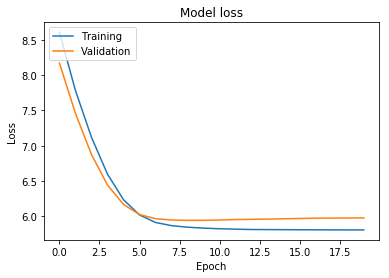

In [13]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

epochs = 20
batch_size = 128

# Stop training when a monitored quantity has stopped improving after 20 epochs
early_stop = EarlyStopping(patience=20, verbose=1)

# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(factor=0.3, patience=3, cooldown=3, verbose=1)

# Save the best model after every epoch
check_point = ModelCheckpoint(filepath='../saved_models/model_weights.hdf5', 
                               verbose=1, save_best_only=True)
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1,
                             validation_data=(X_val, y_val), 
                             callbacks=[check_point, early_stop, reduce_lr])

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.savefig('../plots/model_loss.pdf', bbox_inches='tight')
plt.show()

## Test the real time auto-complete

In [16]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [42]:
from keras.preprocessing.sequence import pad_sequences

test_text = "Do you know what"

print('Test text:', test_text)
temperature = 1.2

outputs = [test_text]
for _ in range(50):
    clean_text = []
    for word in word_tokenize(test_text):
        if word.isalpha():
            clean_text.append(word)
    text_sequences = tokenizer.texts_to_sequences(clean_text)
    sequences = []
    for sequence in text_sequences:
        for seq in sequence:
            sequences.append(seq)
    
    # Truncate sequences to a fixed length
    test_text_encoded = pad_sequences([sequences], maxlen=max_len, truncating='pre')
    preds = model.predict(test_text_encoded, verbose=0)[0]
    yhat = sample(preds, temperature)
        
    # map predicted word index to word
    out_word = ''
    for word, index in word_index.items():
        if index == yhat:
            out_word = word
            break
            
    #if out_word == EOS:
        #break
        
    outputs.append(out_word)
    test_text += " " + out_word
            
print(" ".join(outputs))

Test text: Do you know what
Do you know what not what in who ran i what purification spent you worst brings woman my damn blender tonight better i gums just fishing do have you rolodex youve mate the bad im yes up there you versa and you i someone out incinerator one smuckers no thought danny eos he the
